Note: The code for the notebook was adapted from the following source: Transfer Learning for NLP: Fine-Tuning BERT for Text Classification. The original code can be found at: https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/.

In [1]:
import pandas as pd
df = pd.read_csv('merged_df_final.csv')

In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 KB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.8/661.8 KB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 KB 13.1 MB/s eta 0:00:00
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Load packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#view dataset
df

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description sufficient,Reason if insufficient
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,no,other
1,b74aee44-454b-4eb3-9fec-0064eef530d9,Keep,Corporate Functions,Mental wellbeing in critical times: from confl...,"""Transformations are challenging. They also of...",NaN,NaN
2,70ca382a-aeb3-49b8-8465-009a4bb7932e,Keep,NBS,TPRM Training Sessions for Business Owners-Europe,"""We would like to invite you to familiarize yo...",NaN,NaN
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,yes,NaN
4,e055ddf9-4c8c-49c0-a96a-012100c43d16,Keep,NIBR,Beyond Awareness: Anti-racism in Action,Part 1 (15 Oct 2021: 10-11am ET) Interview wit...,NaN,NaN
...,...,...,...,...,...,...,...
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,NaN,NaN
7610,f2c6ff41-0cf1-44be-a9f5-9c5bf5f6e27b,Keep,Corporate Functions,Rewards & Recognition and Evolve,Join us for this webinar to build your underst...,NaN,NaN
7611,5bee5053-69e0-4bba-ab5e-9c77666f0053,Keep,NBS,Team Effectiveness Awareness Session for P&O/TODI,"In attending this session, you will familiariz...",NaN,NaN
7612,8ae7f112-0aa1-4d79-a872-9c8d3b10a076,Keep,Novartis Learning Institute,Communicate to Connect,The Communicate to Connect program enables an ...,NaN,NaN


In [5]:
#rename the columns
df = df.rename(columns={'Description sufficient': 'Description_sufficient'})
df = df.rename(columns={'Reason if insufficient': 'Reason_if_insufficient'})
df['Description_sufficient'] = df['Description_sufficient'].map({'yes': 1,'Yes':1, 'no':0})

In [6]:
#Make a training dataset that only includes observations that are labeled
Trainingset = df[df['Description_sufficient'].notna()]
Trainingset['Description_sufficient'] = Trainingset['Description_sufficient'].astype(int)
Trainingset

/tmp/ipykernel_89/2172376489.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trainingset['Description_sufficient'] = Trainingset['Description_sufficient'].astype(int)


,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0,other
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,1,NaN
5,520ba579-3762-4af4-8319-014a35a436e0,Keep,NBS,SAP Ariba Sourcing User Training,"""In this virtual training Procurement team mem...",1,NaN
9,a816c41e-4a5b-425f-b334-01c6c86ff2b2,Keep,SANDOZ,SDZ BCD_High Impact Meeting Facilitation,High Impact Meeting Facilitation Training for ...,0,missing relevance
11,70c34fce-05be-4ad8-8f36-0027e236db1a,Keep,NBS,SubWay Regulatory Core Labeling Author Course,Describes how to perform tasks and responsibil...,1,NaN
...,...,...,...,...,...,...,...
7535,f6ff4a18-b384-46a9-8c9c-9926910e3dd4,Keep,Novartis Learning Institute,New Employee Orientation (NEO),New Employee Orientation program is designed t...,1,NaN
7539,81c43a37-95ba-4a61-aa43-758f468964a5,Keep,Global Drug Development,NOVOPEX- OPEX Capability Program,NOVOPEX is an India OPEX Capability Build Prog...,1,NaN
7543,66715ce8-4380-46c9-9955-75d7e2b22012,Keep,NBS,TPRM Training for Business Owners-Mandarin Ses...,We would like to invite you to familiarize you...,1,NaN
7575,7962ca50-6e02-4396-b411-636ecbd8b920,Keep,SANDOZ,2022_SSM PD_GCP_LLN,GCP-related lessons learned relevant to Sandoz...,0,missing relevance and context


In [7]:
X1= Trainingset['NVS_Course_Description_x']#explanatory variable
y1= Trainingset['Description_sufficient']#outcome variable

In [8]:
#Split in training, validation and test data set
# 70% of the sample is used to train the model 
train_text, temp_text, train_labels, temp_labels = train_test_split(X1, y1, 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=y1)


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [9]:
# Import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot: >

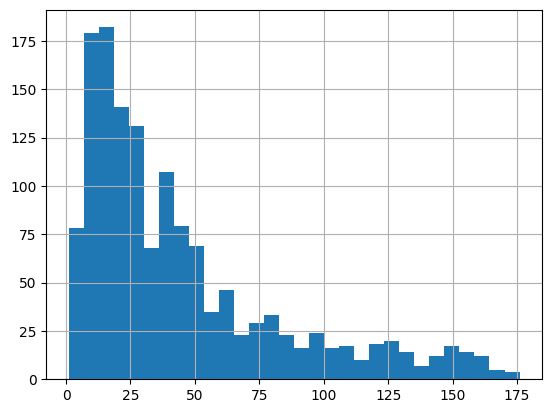

In [10]:
# get length of all the descriptions in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [11]:
#set max length to 80
max_seq_len = 80

In [12]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [15]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [16]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

#push the model to GPU, to run faster
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [18]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

2023-05-05 10:04:46.343231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-05 10:04:46.460508: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-05 10:04:46.464646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-05 10:04:46.464661: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [19]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights for imbalanced dataset
class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.72685656 1.60201794]


In [20]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [21]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [22]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [23]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model on training data
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


 Epoch 1 / 10

Evaluating...

 Epoch 2 / 10

Evaluating...

 Epoch 3 / 10

Evaluating...

 Epoch 4 / 10

Evaluating...

 Epoch 5 / 10

Evaluating...

 Epoch 6 / 10

Evaluating...

 Epoch 7 / 10

Evaluating...

 Epoch 8 / 10

Evaluating...

 Epoch 9 / 10

Evaluating...

 Epoch 10 / 10

Evaluating...


In [24]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [25]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [26]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.93      0.59      0.72       211
           1       0.50      0.90      0.64        96

    accuracy                           0.68       307
   macro avg       0.71      0.74      0.68       307
weighted avg       0.79      0.68      0.69       307



In [27]:
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,124,87
1,10,86


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09374e14-43a4-4eee-b362-608228cad85e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>